# Traditional Time series Forecasting Model

In [1]:
dir_ = 'C:/Users/Ronit/BTP/' # input only here

In [2]:
raw_data_dir = dir_+'data/'
processed_data_dir = dir_+'processed/'

In [3]:
import numpy as np
import pandas as pd
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from helper_func import get_memory_usage , size_of_fmt , reduce_dtypes , merge_by_concat

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import warnings
warnings.filterwarnings("ignore")

D:\Anaconda_ev\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [4]:
########################### Load Data #################################################################################
print('Main Data loaded')

raw_train_df = pd.read_csv(raw_data_dir+'sales_train_evaluation.csv')
raw_prices_df = pd.read_csv(raw_data_dir+'sell_prices.csv')
raw_calendar_df = pd.read_csv(raw_data_dir+'calendar.csv')

Main Data loaded


In [5]:
raw_train_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [6]:
raw_train_df.sample(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
25518,HOUSEHOLD_2_030_WI_2_evaluation,HOUSEHOLD_2_030,HOUSEHOLD_2,HOUSEHOLD,WI_2,WI,1,1,2,0,...,0,1,1,0,0,0,1,0,2,0
11224,FOODS_2_251_CA_4_evaluation,FOODS_2_251,FOODS_2,FOODS,CA_4,CA,3,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Train/Val split 
* Training and validation sets to train and validate our models. we used the last 30 days' sales as the validation data and the sales of the 70 days before that as the training data. We need to predict the sales in the validation data using the sales in the training data.

In [26]:
d_cols = [c for c in raw_train_df.columns if 'd_' in c]
train_dataset = raw_train_df[d_cols[-120:-30]]
val_dataset = raw_train_df[d_cols[-30:]]

In [27]:
train_dataset.head()

,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911
0,0,0,1,1,1,0,0,1,1,1,...,0,1,1,3,0,1,1,1,3,0
1,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,1,0,0,0,...,1,2,2,1,2,1,1,1,0,1
3,8,2,1,2,2,5,2,6,1,0,...,3,0,1,0,5,4,1,0,1,3
4,3,0,0,1,1,0,3,1,0,4,...,1,1,2,1,1,0,1,1,2,2


In [28]:
test_dataset.head()

,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,1,1,0,0,0,2,0,3,5,0,...,2,4,0,0,0,0,3,3,0,1
1,0,0,0,1,0,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,1,1,0,0,1,1,0,2,1,0,...,1,0,2,0,0,0,2,3,0,1
3,7,2,0,0,1,2,4,1,6,4,...,1,1,0,4,0,1,3,0,2,6
4,2,4,1,0,2,3,1,0,3,2,...,0,0,0,2,1,0,0,2,1,0


In [29]:
train_dataset.loc[0].values

array([0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 2, 2, 0, 0, 1, 4, 0,
       0, 0, 0, 1, 1, 2, 0, 4, 0, 1, 0, 1, 4, 2, 0, 2, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 3, 0, 0, 0, 1, 1, 1, 3, 1, 3, 1, 2, 2, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 4, 2, 3, 0, 1, 2, 0, 0, 0, 1, 1, 3, 0, 1, 1, 1,
       3, 0], dtype=int64)

In [30]:
val_dataset.loc[0].values

array([1, 1, 0, 0, 0, 2, 0, 3, 5, 0, 0, 1, 1, 0, 2, 1, 2, 2, 1, 0, 2, 4,
       0, 0, 0, 0, 3, 3, 0, 1], dtype=int64)

In [31]:
# sublots usign various subsets

fig = make_subplots(rows=3, cols=1, subplot_titles=[" Item : HOBBIES_1_001 ", "Item : FOODS_1_058", "Item : HOBBIES_1_003"])

# Subplot 1
fig.add_trace(go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"), showlegend=True,name="Train Data - Original signal"),row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"), showlegend=True,name="Test Data - Preds"), row=1, col=1)

# Subplot 2
fig.add_trace(go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[10].values, marker=dict(color="dodgerblue"), showlegend=True),row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[10].values, mode='lines', marker=dict(color="darkorange"), showlegend=True,),row=2, col=1)

# Subplot 3
fig.add_trace(go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1600].values, marker=dict(color="dodgerblue"), showlegend=True,),row=3, col=1)

fig.add_trace(go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1600].values, mode='lines', marker=dict(color="darkorange"), showlegend=True,),row=3, col=1)

fig.update_layout(height=1100, width=800, title_text="Train (blue) vs. Validation (orange) sales")
fig.show()


### Naive approach (Base Line)
Naive approach. It simply forecasts the next day's sales as the current day's sales. The model can be summarized as follows:

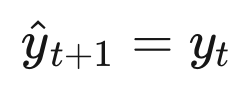

In the above equation, yt+1 is the predicted value for the next day's sales and yt is today's sales. The model predicts tomorrow's sales as today's sales. The training data is represetned in blue and test data in orange, and predictions in green.

In [32]:
predictions = []
for i in range(len(val_dataset.columns)):
    if i == 0:
        predictions.append(train_dataset[train_dataset.columns[-1]].values)
    else:
        predictions.append(val_dataset[val_dataset.columns[i-1]].values)
    
predictions = np.transpose(np.array([row.tolist() for row in predictions]))
error_naive = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

### Visualizing Predictions

In [33]:
pred_1 = predictions[0]
pred_2 = predictions[10]
pred_3 = predictions[1600]

fig = make_subplots(rows=3, cols=1)

#  subplot 1
fig.add_trace(go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"), name="Train"),row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),name="Val"),row=1, col=1)

fig.add_trace( go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"), name="Pred"),row=1, col=1)

# subplot 2
fig.add_trace( go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[10].values, marker=dict(color="dodgerblue"), showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[10].values, mode='lines', marker=dict(color="darkorange"), showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,name="Denoised signal"),row=2, col=1)

#subplot 3
fig.add_trace(go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1600].values, marker=dict(color="dodgerblue"), showlegend=False),row=3, col=1)

fig.add_trace(go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1600].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),row=3, col=1)

fig.add_trace(go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,name="Denoised signal"),row=3, col=1)

fig.update_layout(height=1000, width=800, title_text="Moving average")
fig.show()


In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics for the first prediction (pred_1)
mse_1 = mean_squared_error(val_dataset.loc[0].values, pred_1)
mae_1 = mean_absolute_error(val_dataset.loc[0].values, pred_1)
r2_1 = r2_score(val_dataset.loc[0].values, pred_1)

# Calculate metrics for the second prediction (pred_2)
mse_2 = mean_squared_error(val_dataset.loc[10].values, pred_2)
mae_2 = mean_absolute_error(val_dataset.loc[10].values, pred_2)
r2_2 = r2_score(val_dataset.loc[10].values, pred_2)

# Calculate metrics for the third prediction (pred_3)
mse_3 = mean_squared_error(val_dataset.loc[1600].values, pred_3)
mae_3 = mean_absolute_error(val_dataset.loc[1600].values, pred_3)
r2_3 = r2_score(val_dataset.loc[1600].values, pred_3)

print("Metrics for Prediction 1:")
print(f"MSE: {mse_1}")
print(f"MAE: {mae_1}")
print(f"R-squared: {r2_1}")

print("\nMetrics for Prediction 2:")
print(f"MSE: {mse_2}")
print(f"MAE: {mae_2}")
print(f"R-squared: {r2_2}")

print("\nMetrics for Prediction 3:")
print(f"MSE: {mse_3}")
print(f"MAE: {mae_3}")
print(f"R-squared: {r2_3}")


Metrics for Prediction 1:
MSE: 3.3666666666666667
MAE: 1.3
R-squared: -0.8646153846153841

Metrics for Prediction 2:
MSE: 0.06666666666666667
MAE: 0.06666666666666667
R-squared: -1.06896551724138

Metrics for Prediction 3:
MSE: 0.5
MAE: 0.36666666666666664
R-squared: -0.906779661016949


##### Inference 1.
We can see that the forecasts made by the naive approach are not accurate and it is to be expected of such a simple algorithm. We need more complex models which use several time stamps to make forecasts.

### Moving average 
The moving average method is more complex than the naive approach. It calculates the mean sales over the previous 30 (or any other number) days and forecasts that as the next day's sales. This method takes the previous 30 timesteps into consideration, and is therefore less prone to short term fluctuations than the naive approach. The model can be summarized as follows:

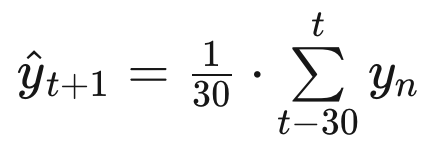

In the above equation, yt+1 is tomorrow's sales. On the right hand side, all the sales for the previous 30 days are added up and divided by 30 to find the average. This forms the model's prediction, yt+1. Now let us see how this new model performs on our miniature dataset. The training data is in blue, validation data in orange, and predictions in green.

In [35]:
predictions = []
for i in range(len(val_dataset.columns)):
    if i == 0:
        predictions.append(np.mean(train_dataset[train_dataset.columns[-30:]].values, axis=1))
    if i < 31 and i > 0:
        predictions.append(0.5 * (np.mean(train_dataset[train_dataset.columns[-30+i:]].values, axis=1) + \
                                  np.mean(predictions[:i], axis=0)))
    if i > 31:
        predictions.append(np.mean([predictions[:i]], axis=1))
    
predictions = np.transpose(np.array([row.tolist() for row in predictions]))
error_avg = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

In [36]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)


fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Moving average")
fig.show()


In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics for the first prediction (pred_1)
mse_1 = mean_squared_error(val_dataset.loc[0].values, pred_1)
mae_1 = mean_absolute_error(val_dataset.loc[0].values, pred_1)
r2_1 = r2_score(val_dataset.loc[0].values, pred_1)

# Calculate metrics for the second prediction (pred_2)
mse_2 = mean_squared_error(val_dataset.loc[10].values, pred_2)
mae_2 = mean_absolute_error(val_dataset.loc[10].values, pred_2)
r2_2 = r2_score(val_dataset.loc[10].values, pred_2)

# Calculate metrics for the third prediction (pred_3)
mse_3 = mean_squared_error(val_dataset.loc[1600].values, pred_3)
mae_3 = mean_absolute_error(val_dataset.loc[1600].values, pred_3)
r2_3 = r2_score(val_dataset.loc[1600].values, pred_3)

print("Metrics for Prediction 1:")
print(f"MSE: {mse_1}")
print(f"MAE: {mae_1}")
print(f"R-squared: {r2_1}")

print("\nMetrics for Prediction 2:")
print(f"MSE: {mse_2}")
print(f"MAE: {mae_2}")
print(f"R-squared: {r2_2}")

print("\nMetrics for Prediction 3:")
print(f"MSE: {mse_3}")
print(f"MAE: {mae_3}")
print(f"R-squared: {r2_3}")


Metrics for Prediction 1:
MSE: 1.8216784431519941
MAE: 1.0700452712172757
R-squared: -0.008929599284181133

Metrics for Prediction 2:
MSE: 0.04241673583136938
MAE: 0.14466495728055598
R-squared: -0.3163814568356018

Metrics for Prediction 3:
MSE: 0.42657170085933005
MAE: 0.6049548191756551
R-squared: -0.6267564863279536


##### Inference 2
We can see that this model performs better than the naive approach. It is less susceptible to the volatility in day-to-day sales data and manages to pick up trends with slightly higher accuracy. However, it is still unable to find high-level trends in the sales.